##### Modelo SEIR (Susceptibles, Expuestos, Infectados, Recuperados)

In [1]:
import numpy as np
import scipy
import scipy.integrate

def seir_model(SEIR, beta, sigma, gamma):
    S, E, I, R = SEIR
    
    # Poblacion
    N = S + E + I + R
    
    dS = - beta * S * I / N
    dE = beta * S * I / N - sigma * E
    dI = sigma * E - gamma * I
    dR = gamma * I
    
    return [
        dS, dE, dI, dR
    ]

Diferencias en los valores respecto a las razones de cambio:  
    * `beta` es la razon de transmision  
    * `sigma` es la razon de transicion de Expuesto a Infectado  
    * `gamma` es la razon de transicion de Infectado a Recuperado (o aislado)  

In [2]:
def run(SEIR, beta, sigma, gamma, days=1, step=0.1):
    steps = np.arange(start=0, stop=days, step=step)
    return scipy.integrate.solve_ivp(
        lambda _, SEIR_t: seir_model(SEIR_t, beta, sigma, gamma),
        y0 = SEIR,
        t_eval = steps,
        t_span = (0, days)
    )

Integramos el sistema de ecuaciones diferenciales en el intervalo [0, days)

In [3]:
from matplotlib import pyplot

pyplot.rcParams['figure.figsize'] = [50/2.54, 22/2.54]

def plot(x, *curves):
    fig, ax = pyplot.subplots()
    for curve in curves:
        ax.plot(x[:len(curve)], curve)

    pyplot.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)

import csv

# https://github.com/mauforonda
with open('./data/covid19-bolivia2/nacional.csv') as f:
    csv_file = csv.reader(f)
    data = [int(line[1]) for idx, line in enumerate(csv_file) if idx > 0]

In [4]:
R0 = 3.
periodo_incubacion = 5.2
periodo_infeccioso = 12.4

`Rt` es el numero reproductivo, representando el numero promedio de nuevas infecciones en el tiempo `t` por infectado.  
Si `Rt` es < 1 la incidencia de nuevas enfermedades decrece, si es > 1 aumenta hasta alcanzar inmunidad de grupo.  
`R0` es este numero antes de cualquier intervencion.

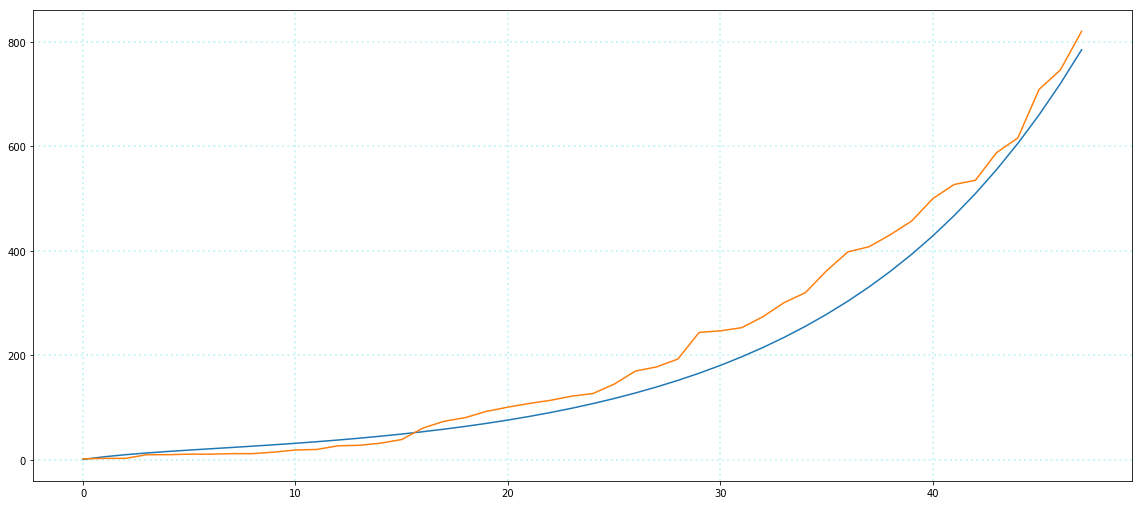

In [5]:
susceptibles_t0 = 11e6
expuestos_t0 = 30
infectados_t0 = 1
dias_simulados = len(data)

SEIR_t0 = (
    susceptibles_t0,
    expuestos_t0,
    infectados_t0,
    0
)
solution = run(
    SEIR_t0,
    beta = R0 / periodo_infeccioso,
    sigma = 1 / periodo_incubacion,
    gamma = 1 / periodo_infeccioso,
    days = dias_simulados,
    step = 1
)

plot(solution['t'], solution['y'][2], data)

##### Intervenciones

Como y cuando intervino el gobierno? 

| Fecha    	| Intervencion                         	|  
|----------	|--------------------------------------	|
| 12/03/20 	| cierre de colegios/universidades     	|
|          	| prohibicion de reuniones > 1000      	|
|          	| cuarentena oruro                     	|
| 15/03/20 	| aislamiento social de casos posibles 	|
| 16/03/20 	| cuarentena potosi, chuquisaca        	|
| 17/03/20 	| transporte terrestre interdepartamental 	|
| 18/03/20 	| distanciamiento social               	|
|          	| media jornada laboral                	|
|          	| prohibicion de reuniones > 100       	|
| 21/03/20 	| cierre fronteras terrestre/aereo     	|
| 22/03/20 	| cuarentena nacional                  	|

Cual es el efecto de estas intervenciones en `Rt`?

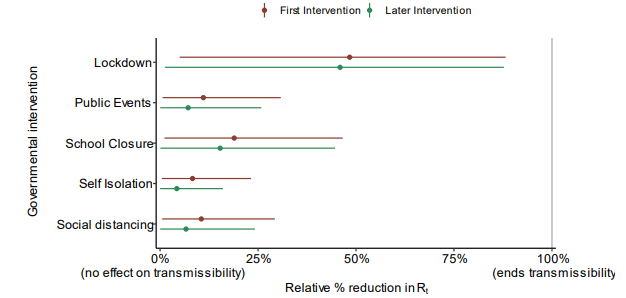
<center>Efecto estimado de intervenciones</center>
<center>Imagen tomada de https://doi.org/10.25561/77731</center>

In [6]:
def run(SEIR, days, step=0.1, **kwargs):
    if type(days) is not list:
        days = [days]
    
    final_solution = None
    acc_days = 0
    
    for point_idx, point_days in enumerate(days):
        args = kwargs.copy()
        for key in args:
            if type(args[key]) == list:
                args[key] = args[key][point_idx]
                
        steps = np.arange(start=acc_days, stop=acc_days + point_days, step=step)
        solution = scipy.integrate.solve_ivp(
            lambda _, SEIR_t: seir_model(SEIR_t, **args),
            y0 = SEIR,
            t_eval = steps,
            t_span = (acc_days, acc_days + point_days)
        )
        
        SEIR = [_[-1] for _ in solution['y']]
        acc_days = acc_days + point_days
        
        if not final_solution:
            final_solution = solution
        else:
            final_solution['t'] = np.append(final_solution['t'], solution['t'])
            final_solution['y'] = [
                np.append(final_solution['y'][idx], solution_y) for idx, solution_y in enumerate(solution['y'])
            ]
        
    return final_solution

Ahora los parametros pueden ser listas (arrays) que se usan en el modelo segun la cantidad de dias en `days`

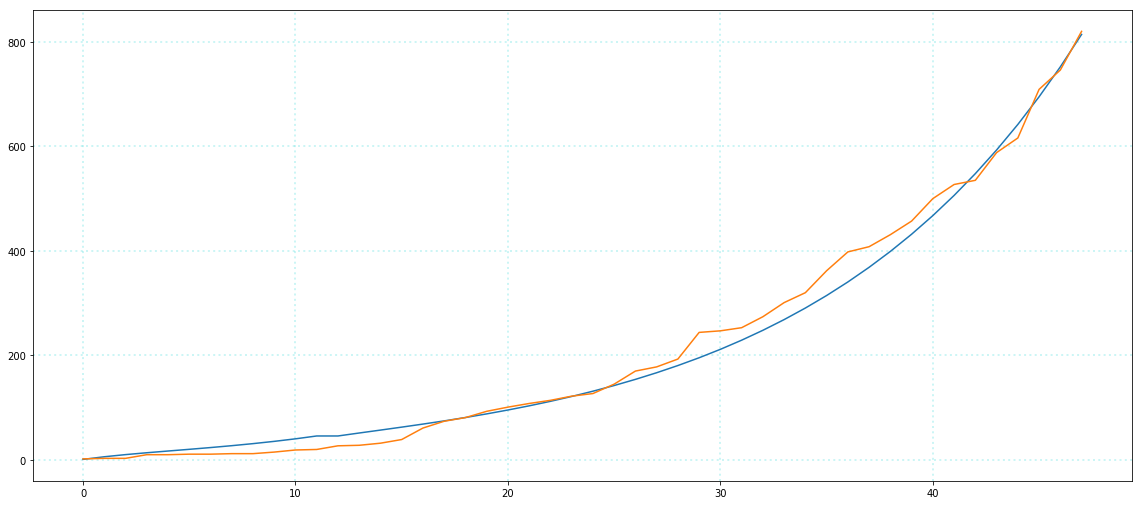

In [8]:
days = [12, 36]
R_ts = [4.2, 2.8]

solution = run(
    SEIR_t0,
    days,
    beta = [R_t / periodo_infeccioso for R_t in R_ts],
    sigma = 1 / periodo_incubacion,
    gamma = 1 / periodo_infeccioso,
    step = 1,
)
plot(solution['t'], solution['y'][2], data)

Notas:

* Mejor ajuste, pero los valores no tienen sentido.
    * `Rt` despues de la cuarentena nacional deberia ser < 2.
* El modelo es muy susceptible a los infectados y expuestos en `t0`.
    * El 26 de marzo (dia 17) habian detectados 24 importados y 27 locales https://bit.ly/2zzETQx

Que hacer ahora?

* Esto no suena muy predictivo, mas bien agregar clases y ver cuales son los max/min comportamientos frente a ciertas constricciones.
* Agregar Fallecidos al modelo.
* Asintomaticos, Pre-Sintomaticos, Serial Interval.
* Hay datos de ingreso al pais (aduana, migracion, sabsa)? Podrian servir para estimar la cantidad de importados iniciales, teniendolos dia a dia desde mediados de febrero desde los paises que importamos mas casos positivos (ESP, USA, ITA https://bit.ly/2SgSVgw) y relacionarlo con la cantidad de infectados esos dias en cada uno de esos paises.